In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#data normalize

In [ ]:
dfbase = pd.read_excel('/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/base_unificada.xlsx')
ibovespa_data = pd.read_csv("/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/ibovespa_2005_2023.csv")
hist_stock_data = pd.read_csv("/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/cota_his_stock/hist_stock.csv")
acoes_data = pd.read_excel("/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/acoes_mais_tempo_ibovespa.xlsx")

In [ ]:
hist_stock_data = hist_stock_data.drop("Unnamed: 0", axis = 1)
hist_stock_data['Date'] = pd.to_datetime(hist_stock_data['Date'])

tickers = acoes_data['Ação'].unique()

hist_stock_more_time = hist_stock_data[hist_stock_data['Ticker'].isin(tickers)]
hist_stock_more_time = hist_stock_more_time.pivot(index='Date', columns='Ticker', values='Closing Price')

hist_stock_more_time.fillna(method='ffill', inplace=True)
hist_stock_more_time.fillna(method='bfill', inplace=True)

In [ ]:
dfbase['data'] = pd.to_datetime(dfbase['data'])
dfbase = dfbase.sort_values('data')
dfbase.fillna(method='ffill', inplace=True)
dfbase.fillna(method='bfill', inplace=True)

In [ ]:
dfbase_variable_1 = dfbase[['data', 'ultimo_valor','volume','bmp_inv_carteira','ke','ke_ipca','ke_selic_dia','ke_cpi','crescimento_pib']]

In [ ]:
merged_data_01 = pd.merge(dfbase_variable_1, hist_stock_more_time, left_on='data', right_on='Date', how='inner')

merged_data_01.fillna(merged_data_01.mean(), inplace=True)

<ipython-input-37-5d1cb37e909a>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  merged_data_01.fillna(merged_data_01.mean(), inplace=True)


In [ ]:
dfbase_variable_1.set_index('data', inplace=True)
merged_data_01.set_index('data', inplace=True)

#SARIMA - bmp_inv_carteira','ke','ke_ipca','ke_selic_dia','ke_cpi','crescimento_pib

In [ ]:
train = dfbase_variable_1.iloc[:-30]
test = dfbase_variable_1.iloc[-30:]

endog_train = train['ultimo_valor']
exog_train = train.drop('ultimo_valor', axis=1)

In [ ]:
model = auto_arima(endog_train, exogenous=exog_train, seasonal=True, stepwise=True, trace=True,
                   suppress_warnings=True, m=12, d=None, D=None, error_action='ignore',
                   out_of_sample_size=30, scoring='mse')

print(model.summary())

In [ ]:
model = SARIMAX(endog=endog_train, exog=exog_train, order=(2,1,2))
results = model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


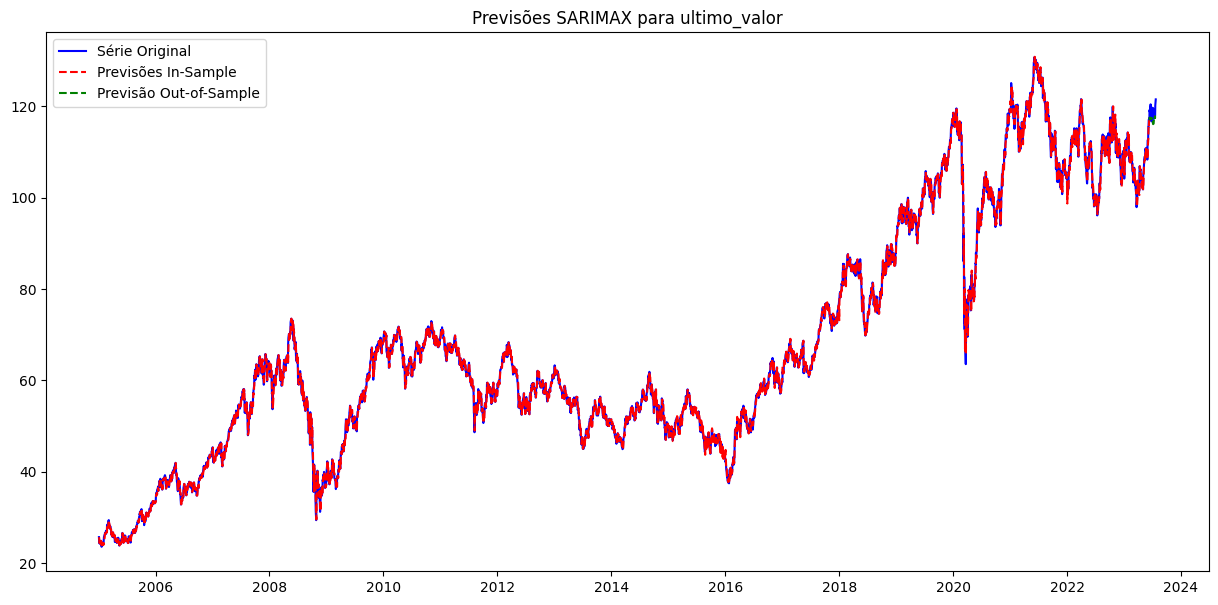

In [ ]:
pred_insample = results.predict(start=1, end=len(train)-1, dynamic=False, exog=exog_train[1:])
exog_test = test.drop('ultimo_valor', axis=1)
forecast_30 = results.get_forecast(steps=30, exog=exog_test).predicted_mean

# Plotting the results
plt.figure(figsize=(15,7))
plt.plot(dfbase_variable_1['ultimo_valor'], label='Série Original', color='blue')
plt.plot(train.index[1:], pred_insample, label='Previsões In-Sample', color='red', linestyle='--')
plt.plot(test.index, forecast_30, label='Previsão Out-of-Sample', color='green', linestyle='--')
plt.title('Previsões SARIMAX para ultimo_valor')
plt.legend()
plt.show()

In [ ]:
print(results.summary())

mse = mean_squared_error(train['ultimo_valor'][1:], pred_insample)
mae = mean_absolute_error(train['ultimo_valor'][1:], pred_insample)
r2 = np.corrcoef(train['ultimo_valor'][1:], pred_insample)[0,1]**2

print(f'\nMean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'R-squared: {r2}')
print(f'\nVariáveis utilizadas: {dfbase_variable_1.columns}')

                               SARIMAX Results                                
Dep. Variable:           ultimo_valor   No. Observations:                 4652
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -6940.068
Date:                Mon, 28 Aug 2023   AIC                          13904.136
Time:                        17:39:00   BIC                          13981.474
Sample:                             0   HQIC                         13931.341
                               - 4652                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
volume           -5.825e-05      0.000     -0.293      0.769      -0.000       0.000
bmp_inv_carteira -4.947e-06   1.05e-05     -0.472      0.637   -2.55e-05    1.56e-05
ke                -473.2513 

#SARIMA - hist stock + bmp_inv_carteira','ke','ke_ipca','ke_selic_dia','ke_cpi','crescimento_pib

In [ ]:
train_merged = merged_data_01.iloc[:-30]
endog_train_merged = train_merged['ultimo_valor']
exog_train_merged = train_merged.drop('ultimo_valor', axis=1)

In [ ]:
model_auto = auto_arima(endog_train_merged, exogenous=exog_train_merged, seasonal=True, stepwise=True, trace=True,
                        suppress_warnings=True, m=12, d=None, D=None, error_action='ignore',
                        out_of_sample_size=30, scoring='mse')


In [ ]:
model2 = SARIMAX(endog=endog_train_merged, exog=exog_train_merged, order=(2,1,2))
results2 = model2.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [ ]:
pred_insample = results.predict(start=1, end=len(train_merged)-1, dynamic=False, exog=exog_train_merged[1:])
exog_test_merged = merged_data_01.iloc[-30:].drop('ultimo_valor', axis=1)
forecast_30 = results.get_forecast(steps=30, exog=exog_test_merged).predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


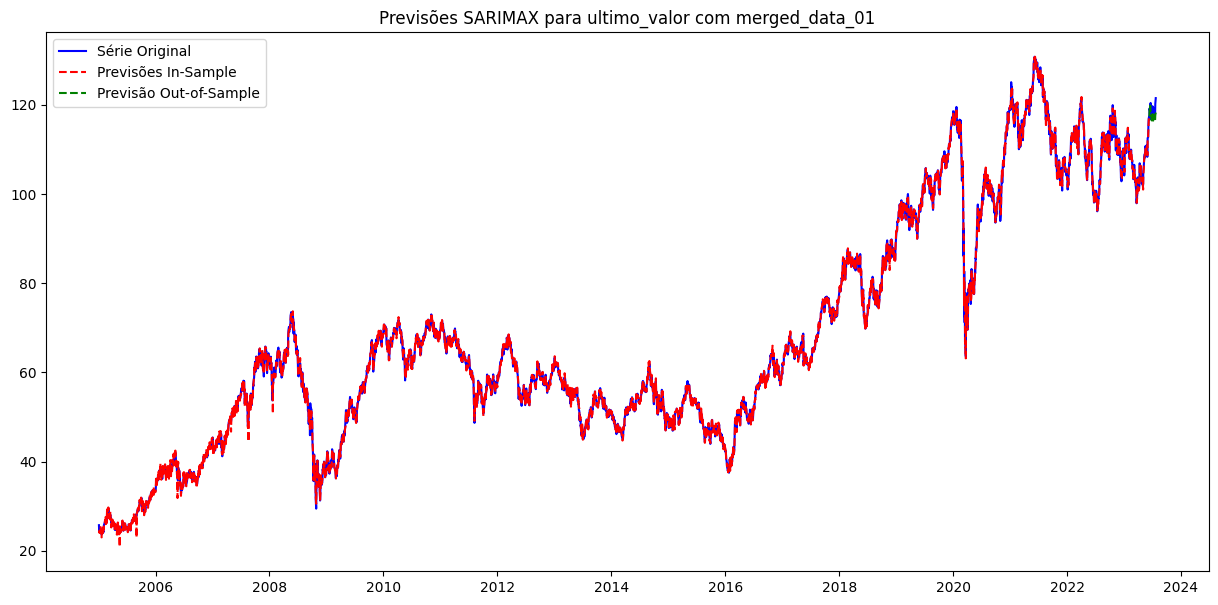

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_01['ultimo_valor'], label='Série Original', color='blue')
plt.plot(train_merged.index[1:], pred_insample, label='Previsões In-Sample', color='red', linestyle='--')
plt.plot(merged_data_01.iloc[-30:].index, forecast_30, label='Previsão Out-of-Sample', color='green', linestyle='--')
plt.title('Previsões SARIMAX para ultimo_valor com merged_data_01')
plt.legend()
plt.show()

In [ ]:
print(results2.summary())

mse = mean_squared_error(train_merged['ultimo_valor'][1:], pred_insample)
mae = mean_absolute_error(train_merged['ultimo_valor'][1:], pred_insample)
r2 = np.corrcoef(train_merged['ultimo_valor'][1:], pred_insample)[0,1]**2

print(f'\nMean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'R-squared: {r2}')
print(f'\nVariáveis utilizadas: {merged_data_01.columns}')

                               SARIMAX Results                                
Dep. Variable:           ultimo_valor   No. Observations:                 4563
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3635.074
Date:                Mon, 28 Aug 2023   AIC                           7328.148
Time:                        18:17:22   BIC                           7514.488
Sample:                             0   HQIC                          7393.762
                               - 4563                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
volume            4.409e-05      0.000      0.387      0.698      -0.000       0.000
bmp_inv_carteira  1.723e-07   7.23e-06      0.024      0.981    -1.4e-05    1.43e-05
ke                -138.3716 